In [3]:
import sys
from pathlib import Path

import pandas as pd

# Add the notebooks directory to the path
sys.path.append(str(Path.cwd().parent))

from charts import (
    latency_box_plot,
    latency_distribution_plot,
    latency_line_plot,
)
from functions import calculate_latencies
from utils import fix_timestamps_timezone

# Kafka to Delta Latencies

In [4]:
experiment_name = "final-01"

df_cloud = pd.read_parquet(f"../../data/raw/{experiment_name}/2026-01-05-14_50_44-avro-cloud.parquet")
df_cloud = df_cloud.sort_values("timestamp") # Kafka append log time | Source timestamp on kafka header was not collected

In [5]:
df_edge = pd.concat([
    pd.read_parquet(f"../../data/raw/{experiment_name}/2026-01-05-17_31_54-avro-edge.parquet"),
    pd.read_parquet(f"../../data/raw/{experiment_name}/rerun/2026-01-05-19_39_25-avro-edge.parquet")
    ])
df_edge = df_edge.sort_values("sent_at_ts") # Source timestamp from kafka header

In [6]:
def fix_timestamps_timezone(df: pd.DataFrame) -> pd.DataFrame:
    df["source_timestamp"] = pd.to_datetime(df["source_timestamp"], unit="ms", utc=True)
    df["source_timestamp"] = df["source_timestamp"].dt.tz_convert("America/Sao_Paulo")
    
    # Subtract 3 hours to correct the offset before localization
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True) - pd.Timedelta(hours=3)
    df["timestamp"] = df["timestamp"].dt.tz_convert("America/Sao_Paulo")

    df["landing_timestamp"] = pd.to_datetime(df["landing_timestamp"], utc=True) - pd.Timedelta(hours=3)
    df["landing_timestamp"] = df["landing_timestamp"].dt.tz_convert("America/Sao_Paulo")

    if "sent_at_ts" in df.columns:
        # sent_at_ts comes as a Long (milliseconds) from Spark/Kafka
        # We explicitly convert to datetime using unit="ms"
        df["sent_at_ts"] = pd.to_datetime(df["sent_at_ts"], unit="ms", utc=True)
        df["sent_at_ts"] = df["sent_at_ts"].dt.tz_convert("America/Sao_Paulo")

    return df

In [7]:
df_edge = fix_timestamps_timezone(df_edge)
df_cloud = fix_timestamps_timezone(df_cloud)

In [8]:
df_cloud["source_timestamp"].min()

Timestamp('2026-01-05 13:11:36.452000-0300', tz='America/Sao_Paulo')

In [9]:
df_cloud["timestamp"].min(), df_cloud["timestamp"].max()

(Timestamp('2026-01-05 13:11:41.465000-0300', tz='America/Sao_Paulo'),
 Timestamp('2026-01-05 14:49:15.919000-0300', tz='America/Sao_Paulo'))

In [10]:
df_edge["timestamp"].min(), df_edge["timestamp"].max()

(Timestamp('2026-01-05 15:30:36.637000-0300', tz='America/Sao_Paulo'),
 Timestamp('2026-01-05 19:38:31.371000-0300', tz='America/Sao_Paulo'))

In [11]:
df_edge["sent_at_ts"].min(), df_edge["sent_at_ts"].max()

(Timestamp('2026-01-05 15:30:36.562000-0300', tz='America/Sao_Paulo'),
 Timestamp('2026-01-05 19:38:31.352000-0300', tz='America/Sao_Paulo'))

In [12]:
def calculate_latencies(df: pd.DataFrame) -> pd.DataFrame:
    df["kafka_landing_latency"] = (
        df["landing_timestamp"] - df["timestamp"]
    ).dt.total_seconds()

    return df

In [13]:
df_cloud = calculate_latencies(df_cloud)
df_edge = calculate_latencies(df_edge)

In [65]:
# Ensure a common schema like: ['environment', 'stage', 'latency_s']
df_edge["environment"] = "Edge"
df_cloud["environment"] = "Cloud"
df = pd.concat([df_edge, df_cloud], ignore_index=True)

In [ ]:
def _prepare_latency_long(df: pd.DataFrame) -> pd.DataFrame:
    """
    Reshape a wide dataframe with latency columns into long form with
    columns: ['environment', 'stage', 'latency_s'].

    Required columns:
      - environment
      - kafka_landing_latency → stage 'Spark' (persistence)
    """
    required = {
        "environment",
        "kafka_landing_latency",
    }
    missing = required - set(df.columns)
    if missing:
        raise KeyError(f"Missing required columns: {sorted(missing)}")

    long_df = df.melt(
        id_vars=["environment"],
        value_vars=[
            "kafka_landing_latency",
        ],
        var_name="metric",
        value_name="latency_s",
    )
    stage_map = {
        "kafka_landing_latency": "Spark",
    }
    long_df["stage"] = pd.Categorical(
        long_df["metric"].map(stage_map),
        categories=["Spark"],
        ordered=True,
    )
    return long_df.drop(columns=["metric"])

In [ ]:
import numpy as np

def summarize_latencies_ms(df: pd.DataFrame) -> pd.DataFrame:
    long_df = _prepare_latency_long(df)
    summ = (
        long_df.groupby(["stage", "environment"])["latency_s"]
        .agg(
            median=lambda s: np.nanmedian(s),
            iqr=lambda s: np.nanpercentile(s, 75) - np.nanpercentile(s, 25),
            p95=lambda s: np.nanpercentile(s, 95),
        )
        .mul(1000)  # seconds -> milliseconds
        .round(1)   # 0.1 ms resolution is sufficient for reporting
        .reset_index()
        .pivot(index=["stage"], columns="environment")
        .sort_index()
    )
    # Make a flat column index like 'median.Edge (ms)'
    summ.columns = [f"{stat}.{env} (ms)" for stat, env in summ.columns]
    return summ

/tmp/ipykernel_3081/2913211786.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  long_df.groupby(["stage", "environment"])["latency_s"]


,median.Cloud (ms),median.Edge (ms),iqr.Cloud (ms),iqr.Edge (ms),p95.Cloud (ms),p95.Edge (ms)
stage,,,,,,
Spark,2765.0,3213.0,2641.0,3215.0,6480.0,7888.0


Spark — Edge median: 3213.0 ms; Cloud median: 2765.0 ms; Cloud P95: 6480.0 ms.


In [ ]:
stats_ms = summarize_latencies_ms(df)
display(stats_ms)

# Convenience accessors for your paragraph (edit rounding as you prefer)
def val(stage, stat, env):
    return float(stats_ms.loc[stage, f"{stat}.{env} (ms)"])

s_edge_med   = val("Spark", "median", "Edge")
s_cloud_med  = val("Spark", "median", "Cloud")
s_cloud_p95  = val("Spark", "p95",    "Cloud")

print(
    f"Spark — Edge median: {s_edge_med:.1f} ms; Cloud median: {s_cloud_med:.1f} ms; "
    f"Cloud P95: {s_cloud_p95:.1f} ms."
)

/home/ark/streaming-pipeline/notebooks/charts.py:1178: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


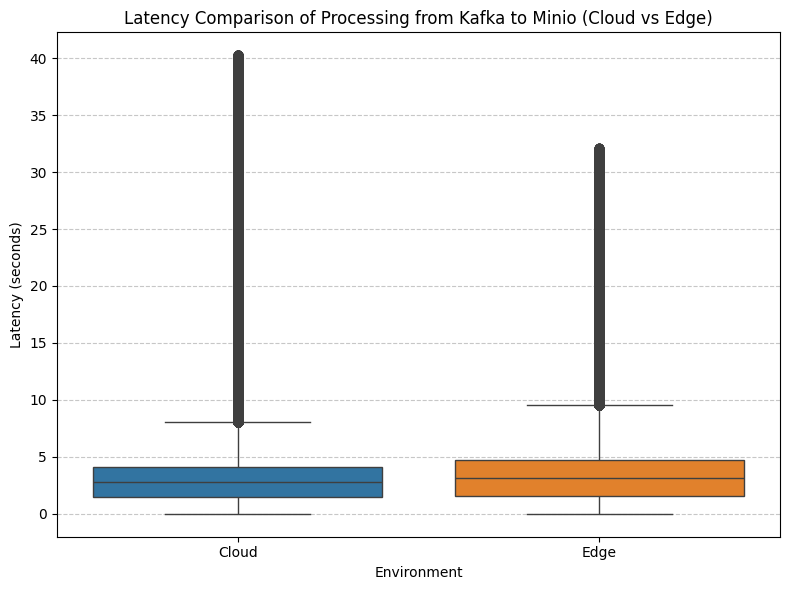

In [14]:
latency_box_plot(df_cloud, df_edge, y="kafka_landing_latency", title="Latency Comparison of Processing from Kafka to Minio (Cloud vs Edge)", save_path="../../data/processed/final-01/latency_box_plot_kafka_landing_cloud_edge.png")

/home/ark/streaming-pipeline/notebooks/charts.py:1221: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  resampled = df.set_index(x)[[y]].resample(rule).agg(["min", "mean", "max"])
/home/ark/streaming-pipeline/notebooks/charts.py:1221: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  resampled = df.set_index(x)[[y]].resample(rule).agg(["min", "mean", "max"])


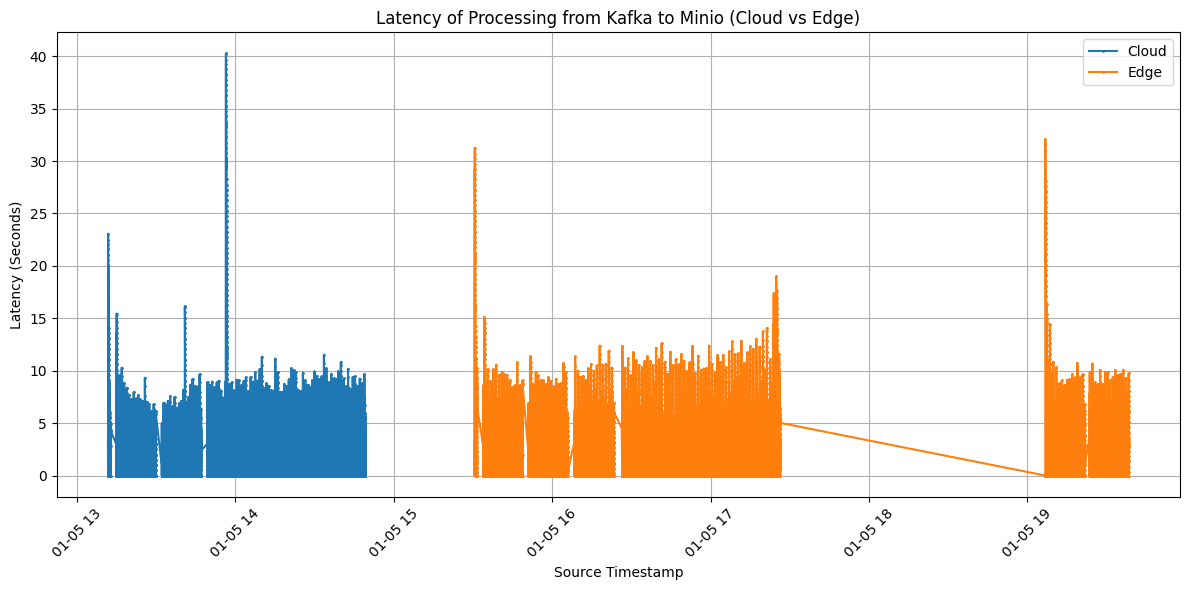

In [15]:
latency_line_plot(df_cloud, df_edge, x='timestamp', y='kafka_landing_latency', title='Latency of Processing from Kafka to Minio (Cloud vs Edge)', linestyle="solid", downsample_rule="1S", save_path="../../data/processed/final-01/latency_line_plot_kafka_landing_cloud_edge.png")

📊 Statistics:
                 mean  median       std
Environment                            
Cloud        3.020596   2.765  2.548525
Edge         3.415170   3.176  2.380129


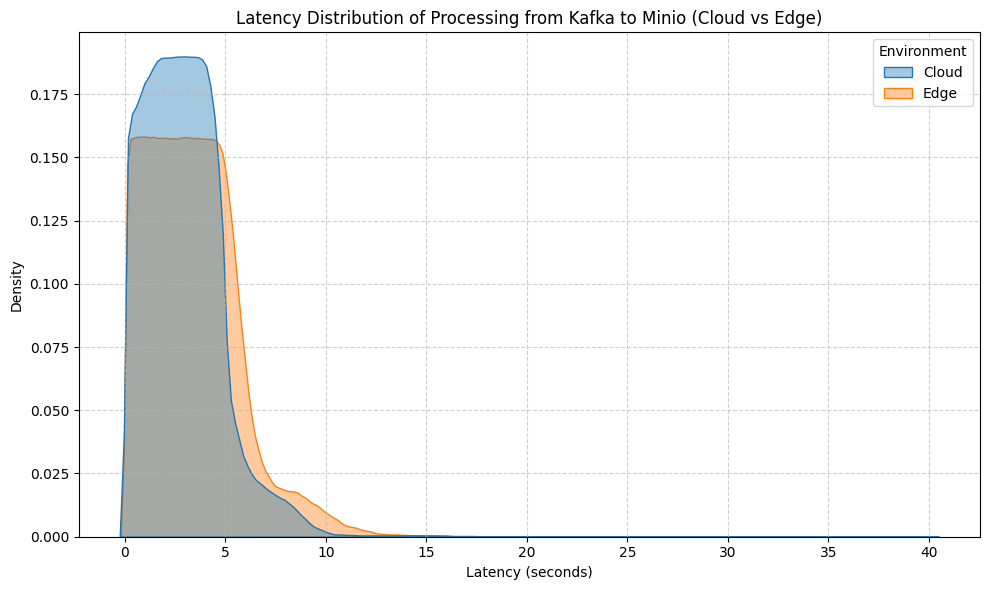

In [16]:
latency_distribution_plot(df_cloud, df_edge, x="kafka_landing_latency", title="Latency Distribution of Processing from Kafka to Minio (Cloud vs Edge)", save_path="../../data/processed/final-01/latency_distribution_kafka_landing_cloud_edge.png")